<div class = "alert alert-block alert-info">
.
├── sms_spam_collection.zip          ← downloaded ZIP
    
├── sms_spam_collection/            ← extracted folder

│   └── SMSSpamCollection.tsv       ← renamed .tsv file
<div>

## Downloading the data

In [36]:
import os

extracted_path = "sms_spam_collection"
data_file_path = os.path.join(extracted_path, "SMSSpamCollection.tsv")

In [37]:
# Reading the dataset
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Labels", "Text"])
df.head(3)

,Labels,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [38]:
# Checking the value counts

df["Labels"].value_counts()

Labels
ham     4825
spam     747
Name: count, dtype: int64

In [39]:
# Creating a balanced dataset - Undersampling

def create_balanced_dataset(dataframe):
    num_samples = dataframe["Labels"].value_counts().min()
    ham_subset = dataframe[dataframe["Labels"] == "ham"].sample(num_samples, random_state=42)
    balanced_df = pd.concat([dataframe[dataframe["Labels"]=="spam"], ham_subset])
    return balanced_df
balanced_df = create_balanced_dataset(df)
balanced_df["Labels"].value_counts()

Labels
spam    747
ham     747
Name: count, dtype: int64

In [40]:
# Label Encoding

balanced_df["Labels"] = balanced_df["Labels"].map({"ham": 0, "spam":1})
balanced_df.head(3)

,Labels,Text
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...


In [41]:
# Splitting data - train = 0.7 test = 0.2 validation = 0.1

def random_split(dataframe, train_frac, validation_frac):
    df = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
    train_end = int(len(df)*train_frac)
    validation_end = int((len(df)*validation_frac)+train_end)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, test_df, validation_df   
train_df, test_df, validation_df = random_split(balanced_df, 0.7, 0.1)

In [42]:
train_df["Labels"].value_counts(),test_df["Labels"].value_counts(),validation_df["Labels"].value_counts()

(Labels
 1    539
 0    506
 Name: count, dtype: int64,
 Labels
 0    164
 1    136
 Name: count, dtype: int64,
 Labels
 0    77
 1    72
 Name: count, dtype: int64)

In [43]:
# Saving the data

train_df.to_csv("train.csv", index=None)
test_df.to_csv("test.csv", index=None)
validation_df.to_csv("val.csv", index=None)

## Creating Input - Pair Targets

Creating Datasets

In [44]:
# Creating the spam dataset class
import torch
import tiktoken
from torch.utils.data import Dataset

# Creating the tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
class SpamDataset(Dataset):
    def __init__(self, tokenizer, csv_file, pad_token_id=50256, max_length=None):
        # Reading data
        self.data = pd.read_csv(csv_file)
        # Pre-Encoding raw text
        self.encoded_texts = [
            tokenizer.encode(encoded_text)
            for encoded_text in self.data["Text"]
        ]
        # Assigning the length = maximum of the lengths
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncating text that are longer than the maximum length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        # Padding shorter sequences
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    # The main method - to be used by dataloader   
    def __getitem__(self, idx):
        encoded = self.encoded_texts[idx]
        label = self.data["Labels"].iloc[idx]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)   
        )
    # Getting the data set length
    def __len__(self):
       return len(self.data)
    # Getting the datasets max length if None 
    def _longest_encoded_length(self):
       max_length = 0
       for encoded_text in self.encoded_texts:
           if len(encoded_text) > max_length:
               max_length = len(encoded_text)
       return max_length        

In [45]:
# Padding the training testing validation datasets

# Training dataset
train_dataset = SpamDataset(
    tokenizer = tokenizer, 
    csv_file = "Train.csv",
)
print(train_dataset.max_length)
testing_dataset = SpamDataset(
    tokenizer = tokenizer,
    csv_file = "Test.csv",
    max_length = train_dataset.max_length
)
print(testing_dataset.max_length)
validation_dataset = SpamDataset(
    tokenizer = tokenizer,
    csv_file = "val.csv",
    max_length=train_dataset.max_length
)
print(validation_dataset.max_length)

137
137
137


Creating Dataloader

In [46]:
# Creating The dataloaders
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)
# Train dataloader
train_dataloader = DataLoader(
    dataset = train_dataset, 
    num_workers = num_workers,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True
)
torch.manual_seed(123)
#  Test dataloader
test_dataloader = DataLoader(
    dataset = testing_dataset, 
    num_workers = num_workers,
    batch_size = batch_size,
    shuffle = True,
    drop_last = False
)
torch.manual_seed(123)
# Validation dataloader
validation_dataloader = DataLoader(
    dataset = validation_dataset, 
    num_workers = num_workers,
    batch_size = batch_size,
    shuffle = True,
    drop_last = False
)
# Checking the lengths of the dataloaders
print(f"The length of the train dataloader \t= {len(train_dataloader)}batches")
print(f"The length of the test dataloader \t= {len(validation_dataloader)}batches")
print(f"The length of the validation dataloader = {len(test_dataloader)}batches")

The length of the train dataloader 	= 130batches
The length of the test dataloader 	= 19batches
The length of the validation dataloader = 38batches


In [47]:
# Checking batch dimensions

iteration = iter(train_dataloader)
input_batch, target_batch = next(iteration)
input_batch.shape, target_batch.shape

(torch.Size([8, 137]), torch.Size([8]))

## Loading pretrained weights

In [48]:
# Defining the GPT configuration settings

GPT_Config_124M = {
    "vocab_size": 50257,
    "context_length": 1024, 
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.0,
    "qkv_bias": True
}

In [49]:
# NB: Input = [b, num_tokens, 768]
import torch
from torch import nn

# 1. Activation function
class GELUActivation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # Pass the input through the GELU activation - Approximate formula
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0) / torch.pi) * (x + 0.44715 * torch.pow(x, 3))))
        
# 2. Layer normalization
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # Defining the epsilon -  small constant added to the variance to prevent zero division - undefined - limits
        self.eps = 1e-5
        # Defining the scaling and shifting parameters - trainable - better results
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.scale = nn.Parameter(torch.ones(emb_dim))
    # Forward pass
    def forward(self, x):
        # Getting the mean and variance of each row
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        # Getting the normalization values
        norm_x = (x - mean) / torch.sqrt(variance + self.eps)
        # Returning the normalized values of x shifted and scaled - finetuning parameters
        return self.scale * norm_x + self.shift
        
# 3. Feed forward        
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"]*4),
            GELUActivation(),
            nn.Linear(cfg["emb_dim"]*4, cfg["emb_dim"])
        )
    def forward(self, x):
        return self.layers(x)
# 4. Attention Mechanism
# Creating the multi-head attention compact class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout_rate, bias_units=False):
        super().__init__()
        assert d_out % num_heads == 0, "dimensions out must be divisible by number of heads"
        # Getting the head dimensions
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        # Initializing the key query value weights - (d_out, d_out)
        self.w_key = nn.Linear(d_in, d_out, bias=bias_units)
        self.w_query = nn.Linear(d_in, d_out, bias=bias_units)
        self.w_value = nn.Linear(d_in, d_out, bias=bias_units)
        # Initializing the final projection layer - optional - (d_out, d_out)
        self.out_proj = nn.Linear(d_out, d_out)
        # Creating the masking layer
        self.register_buffer("mask", torch.triu(
            torch.ones(context_length, context_length),
            diagonal = 1
        ))
        # Creating the dropout layer
        self.dropout = nn.Dropout(dropout_rate)
    # Forward pass    
    def forward(self, x):
        # Exploding the input shape
        b, num_tokens, d_out = x.shape
        # Getting the key query value matrices (b, num_tokens, d_out)
        keys = self.w_key(x)
        queries = self.w_query(x)
        values =  self.w_value(x)
        # Reshaping the key query value matrices - (b, num_tokens, num_head, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        # Grouping by number of heads - (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        # Getting the attention scores - (b, num_heads, num_tokens, num_tokens)
        attention_scores = queries @ keys.transpose(2, 3)
        # Masking the attention scores
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf
        )
        # Scaling the attention scores
        attention_scores = attention_scores / keys.shape[-1]**0.5
        # Getting the attention weights
        attention_weights = torch.softmax(attention_scores, dim=-1)
        # Implementing the dropout layer
        attention_weights = self.dropout(attention_weights)
        # Getting the context vector - (b, num_heads, num_tokens, head_dim)
        context_vector = attention_weights @ values
        # Reshaping the context vectors - (b, num_tokens, num_heads, head_dim)
        context_vector = context_vector.transpose(1, 2)
        # Combining the result of mutiple heads - d_out = num_heads * head_dim
        context_vector = context_vector.contiguous().view(b, num_tokens, d_out)
        # Passing the final context vector into the projection layer - optional
        context_vector = self.out_proj(context_vector)
        return context_vector
# Transformer class        
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Defining the normalization layers
        self.layerNorm1 = LayerNorm(cfg["emb_dim"])
        self.layerNorm2 = LayerNorm(cfg["emb_dim"])
        # Defining the dropout layers
        self.drop_shortcut = nn.Dropout(cfg["dropout_rate"])
        # Defining the Multi-Head Attention layer
        self.attention = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            num_heads = cfg["n_heads"],
            context_length = cfg["context_length"],
            dropout_rate = cfg["dropout_rate"],
            bias_units = cfg["qkv_bias"]
        )
        # Deefining the feed forward layer
        self.feed_forward = FeedForward(cfg)
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut1 = x
        x = self.layerNorm1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        # Add the original input the output 
        x = x +  shortcut1
        # Shortcut connection for the 
        shortcut2 = x
        x = self.layerNorm2(x)
        x = self.feed_forward(x)
        x = self.drop_shortcut(x)
        # Add the original output
        x = x + shortcut2
        return x
# Gpt model        
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Defining the token embedding layer
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # Defining the positional embedding layer
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Defining the dropout layer 
        self.drop_emb = nn.Dropout(cfg["dropout_rate"])
        # Defining the transformer blocks
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        # Defining the final normalization layer
        self.final_norm = LayerNorm(cfg["emb_dim"])
        # Defining the final linear layer
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    # Forward pass
    def forward(self, in_idx):
        # Explosion of shape
        batch_size, seq_len = in_idx.shape
        # Getting the token embeddings
        token_embeddings = self.tok_emb(in_idx)
        # Getting the positional embeddings
        positional_embeddings = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # Getting the input embeddings
        input_embeddings = token_embeddings + positional_embeddings
        # Passing the input embeddings through the dropout layer
        input_embeddings = self.drop_emb(input_embeddings)
        # Passing the input embeddings through the transformer blocks
        input_embeddings = self.transformer_blocks(input_embeddings)
        # Passing the input embeddings through the final normalization layer
        input_embeddings = self.final_norm(input_embeddings)
        # Passint the input embeddings through the final linear layer to get logits
        logits = self.out_head(input_embeddings)
        return logits        

In [50]:
# Loading the state dictionary - from pretrained weights

gpt_openAI = GPTModel(GPT_Config_124M)
gpt_openAI.load_state_dict(torch.load(r"C:\Users\nyasa\Downloads\gpt2\gpt_openAI.pth"))
gpt_openAI.eval()

C:\Users\nyasa\AppData\Local\Temp\ipykernel_7108\1150959550.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gpt_openAI.load_state_dict(torch.load(r"C:\Users\nyasa\Downlo

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layerNorm1): LayerNorm()
      (layerNorm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
      (attention): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELUActivation()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (layerNorm1): LayerNor

In [51]:
test = GPTModel(GPT_Config_124M)
test.load_state_dict(torch.load(r"C:\Users\nyasa\Downloads\gpt2\gpt_openAI.pth"))

C:\Users\nyasa\AppData\Local\Temp\ipykernel_7108\819780029.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test.load_state_dict(torch.load(r"C:\Users\nyasa\Downloads\gpt

<All keys matched successfully>

In [52]:
# Testing if the loading state dictionary was successful

for (k1, v1), (k2, v2) in zip(test.state_dict().items(), gpt_openAI.state_dict().items()):
    if k1!=k2 or not torch.equal(v2, v1):
        print("Mismatch found")
    else:
        print("Models match perfectly")
# Deleting the test model - memory efficiency
del test

Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models match perfectly
Models matc

In [53]:
def generate(model, idx, max_new_tokens, context_size, temp=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        # Slicing to context
        idx_cond = idx[:, -context_size:]
        # Getting the logits
        with torch.no_grad():
            logits = model(idx_cond)
        # Getting the logits for the last prediction task
        logits = logits[:, -1, :]
        # Applying top-k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(input=logits, k=top_k, dim=-1)
            # Getting the smallest top logit value - [b, logits]
            min_val = top_logits[-1].min()
            # -Infinity masking
            logits = torch.where(
                condition = logits < min_val,
                input = torch.tensor(-torch.inf).to(logits.device),
                other = logits
            )
        # Applying temprature scaling
        if temp > 0.0:
           logits = logits / temp
           # Applying softmax
           probabilities = torch.softmax(logits, dim=-1)
           # Getting the next token
           idx_next = torch.multinomial(probabilities, num_samples=1)
        # If temprature is None - use argmax    
        else:
            probabilities = torch.softmax(logits, dim=-1)
            idx_next = torch.argmax(probabilities, dim=-1, keepdim=True)
        # If end of sequence token is encountered end sequence early    
        if idx_next == eos_id:
            break
        # Updating the idx - input
        idx = torch.cat((idx, idx_next), dim=-1)
    # Returning the initial plus predicted tokens    
    return idx    

In [54]:
# Testing model generation ability

token_ids = generate(
    model = gpt_openAI,
    idx = torch.tensor(tokenizer.encode(
        """
        Is the following text spam or not ? Answer with yes or no: 
        'You have been specially selected to receive 2000$ award
        """
    )).unsqueeze(0),
    temp = 1.5, 
    top_k= 10,
    context_size = 1024,
    max_new_tokens=10
)

In [55]:
tokenizer.decode(token_ids.squeeze(0).numpy()).replace("\n", "")

"        Is the following text spam or not ? Answer with yes or no:         'You have been specially selected to receive 2000$ award         p- the  *AUG ' ________________"

In [56]:
# Checking the max length in our dataset doesnt exceed the context length

assert GPT_Config_124M['context_length'] >= train_dataset.max_length, (
    f"Dataset maximum length : {train_dataset.max_length} exceeds model context length"
    f"Context length: {GPT_Config_124M['context_length']} initialize dataset with context length"
    f"Max length = {GPT_Config_124M['context_length']}"
)

## Classifying head

In [57]:
print(gpt_openAI)
gpt_openAI.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layerNorm1): LayerNorm()
      (layerNorm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
      (attention): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELUActivation()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (layerNorm1): LayerNor

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layerNorm1): LayerNorm()
      (layerNorm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
      (attention): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELUActivation()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (layerNorm1): LayerNor

In [58]:
# Checking the number of trainable  parameters

trainable_params1 = sum(p.numel() for p in gpt_openAI.parameters() if p.requires_grad)
print(f"The number of trainable parameters before freezing = {trainable_params1}")

The number of trainable parameters before freezing = 163037184


In [59]:
# Freezing the parameter -  no gradient update means no parameter update

for param in gpt_openAI.parameters():
    param.requires_grad = False

In [60]:
# Replacing the output head with the classifying head

# Defining the number of classes
num_classes = df["Labels"].nunique()
# Replacement 
# It wil receive the embedding dimension
# Instead of mapping it to the vocabulary size 
# It will map to the number of classes we want to predict
torch.manual_seed(42)
gpt_openAI.out_head = nn.Linear(in_features = GPT_Config_124M["emb_dim"], out_features=num_classes)
print(gpt_openAI)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layerNorm1): LayerNorm()
      (layerNorm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
      (attention): MultiHeadAttention(
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELUActivation()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (layerNorm1): LayerNor

In [61]:
# Unfreezing the last transformer blovk and final normalization layer

# For the last normalization layer
for param in gpt_openAI.final_norm.parameters():
    param.requires_grad = True
# For the last transformer block
for param in gpt_openAI.transformer_blocks[-1].parameters():
    param.requires_grad = True

In [62]:
# Checking the number of trainable parameters

trainable_params2 = sum(p.numel() for p in gpt_openAI.parameters() if p.requires_grad)
print(f"Total  number of trainable parameters currently = {trainable_params2}")

Total  number of trainable parameters currently = 7090946


In [63]:
print(f"The difference in trainable parameters = {trainable_params1 - trainable_params2}")

The difference in trainable parameters = 155946238


Creating output with our partially freezed model

In [64]:
# Instead of 768 dimensions we have 2 dimensions

sample_text = "Every effort moves"
encoded = torch.tensor(tokenizer.encode(sample_text)).unsqueeze(0)
with torch.no_grad():
    output = gpt_openAI(encoded)
output.shape, output

(torch.Size([1, 3, 2]),
 tensor([[[0.4555, 1.5141],
          [3.0515, 6.0992],
          [2.8892, 7.2140]]]))

In [65]:
# We will focus on the last output token - because it captures the attention scores for all the tokens

output[:, -1, :]  

tensor([[2.8892, 7.2140]])

## Calculating the loss and accuracy 

In [66]:
# Getting the probabilities from the outputs

probabilities = torch.softmax(output[:, -1, :], dim=-1)
probabilities

tensor([[0.0131, 0.9869]])

In [67]:
# Getting the class label

label = torch.argmax(probabilities, dim=-1)
print(f"Class Label: {label.item()}=spam")

Class Label: 1=spam


a. Accuracy - percentage of correct predictions

In [68]:
# Creating the accuracy function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def calc_accuracy_loader(model, dataloader, num_batches=None):
    num_examples, correct_predictions = 0, 0
    # If batch size not specified
    if num_batches is None:
        num_batches = len(dataloader)
    # If specified it must not exceed length of dataloader
    else:
        num_batches = min(len(dataloader), num_batches)
    # Iterating the dataloader
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            # Getting the logits + last row
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            # Getting the probabilities
            probabilities = torch.softmax(logits, dim=-1)
            # Getting the predicted labels
            predicted_labels = torch.argmax(probabilities, dim=-1)
            # An label for each element in the batch
            num_examples += predicted_labels.shape[0]
            correct_predictions += sum(predicted_labels == target_batch).item()
    # Get the percentage accuracy         
    return correct_predictions / num_examples         

In [69]:
# Getting the initial accuracies before training

gpt_openAI.to(device)
train_accuracy = calc_accuracy_loader(gpt_openAI, train_dataloader, 10)
testing_accuracy = calc_accuracy_loader(gpt_openAI, test_dataloader, 10)
validation_accuracy = calc_accuracy_loader(gpt_openAI, validation_dataloader, 10)
print(f"Training accuracy = {validation_accuracy*100}%")
print(f"Testing accuracy = {testing_accuracy*100}%")
print(f"Validation accuracy = {validation_accuracy*100}%")

Training accuracy = 46.25%
Testing accuracy = 48.75%
Validation accuracy = 46.25%


b. Loss(cross entropy loss) - accuracy is not differentiable

In [70]:
# Creating the loss functions

# Batch loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # Getting the logits for the last row
    logits = model(input_batch)[:, -1, :]
    # Getting the loss
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

# Dataloader loss
def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(len(dataloader), num_batches)
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
    return total_loss / num_batches    

In [71]:
# Getting the initial losses -  before pretraining

# Turning off gradient tracking - we are not training
with torch.no_grad():
    training_loss = calc_loss_loader(train_dataloader, gpt_openAI, device, num_batches=5)
    testing_loss = calc_loss_loader(test_dataloader, gpt_openAI, device, num_batches=5)
    validation_loss = calc_loss_loader(validation_dataloader, gpt_openAI, device, num_batches=5)

print(f"Training loss = {training_loss}")
print(f"Testing loss = {testing_loss}")
print(f"Validation loss = {validation_loss}")

Training loss = 0.9163112163543701
Testing loss = 0.9449475288391114
Validation loss = 0.8160614907741547


## Training loop

In [72]:
from tqdm.auto import tqdm
optimizer = torch.optim.AdamW(gpt_openAI.parameters(), lr=5e-5, weight_decay=0.1)
def evaluate_model(model, device, train_dataloader, testing_dataloader, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(validation_dataloader, model, device, num_batches=eval_iter)
    model.train()    
    return train_loss, val_loss    
def pretraining_loop(model, device, optimizer, train_dataloader, validation_dataloader, num_epochs, eval_iter, eval_freq):
    train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []
    examples_seen, global_step = 0, -1
    for epoch in tqdm(range(num_epochs)):
        # Setting the model to train model
        model.train()
        # Forward pass of all the batches
        for input_batch, target_batch in tqdm(train_dataloader):
            # Resetting the gradients
            optimizer.zero_grad()
            # Calculating the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # Calculating the gradients
            loss.backward()
            # Backpropagation
            optimizer.step()
            global_step+=1
            examples_seen+=input_batch.shape[0]
            # Optional evaluation
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, device, train_dataloader, validation_dataloader, eval_iter)
                train_losses.append(train_loss)
                validation_losses.append(val_loss)
                print(f"epoch: {epoch} - global step: {global_step} - val loss: {val_loss:.3f} - train loss: {train_loss:.3f}")
        # Calculate accuracy after each epoch
        train_acc = calc_accuracy_loader(model, train_dataloader, num_batches=eval_iter)
        val_acc = calc_accuracy_loader(model, validation_dataloader, num_batches=eval_iter)
        train_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)
        print(f"Train accuracy = {train_acc:.3f} - validation accuracy = {val_acc:.3f}")
    return validation_losses, train_losses, validation_accuracies, train_accuracies, examples_seen 

In [73]:
# Training
import time

start_time = time.time()
torch.manual_seed(123)
num_epochs=5
val_losses, train_losses, val_acc, train_acc, examples_seen = pretraining_loop(
    model=gpt_openAI, 
    device=device, 
    optimizer=optimizer,
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader,
    num_epochs=num_epochs,
    eval_iter=2,
    eval_freq=50
)
end_time = time.time()
executed_time = (end_time-start_time)/60
print(f"Execution time = {executed_time} minutes")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

epoch: 0 - global step: 0 - val loss: 0.8385731279850006 - train loss: 0.6725417971611023
epoch: 0 - global step: 50 - val loss: 0.6417063772678375 - train loss: 0.6727611124515533
epoch: 0 - global step: 100 - val loss: 0.563302606344223 - train loss: 0.6159024834632874
Train accuracy = 0.812 - validation accuracy = 0.750


  0%|          | 0/130 [00:00<?, ?it/s]

epoch: 1 - global step: 150 - val loss: 0.5014428794384003 - train loss: 0.5967153906822205
epoch: 1 - global step: 200 - val loss: 0.3675883635878563 - train loss: 0.18023806810379028
epoch: 1 - global step: 250 - val loss: 0.4542751759290695 - train loss: 0.3535231128334999
Train accuracy = 0.812 - validation accuracy = 0.938


  0%|          | 0/130 [00:00<?, ?it/s]

epoch: 2 - global step: 300 - val loss: 0.524035856127739 - train loss: 0.7716647982597351
epoch: 2 - global step: 350 - val loss: 0.3399352878332138 - train loss: 0.05840997397899628
Train accuracy = 0.938 - validation accuracy = 0.875


  0%|          | 0/130 [00:00<?, ?it/s]

epoch: 3 - global step: 400 - val loss: 0.18011756986379623 - train loss: 0.5827115923166275
epoch: 3 - global step: 450 - val loss: 0.14016272127628326 - train loss: 0.6712006032466888
epoch: 3 - global step: 500 - val loss: 0.44937360286712646 - train loss: 0.14336582645773888
Train accuracy = 0.812 - validation accuracy = 0.875


  0%|          | 0/130 [00:00<?, ?it/s]

epoch: 4 - global step: 550 - val loss: 0.1308216191828251 - train loss: 0.468222439289093
epoch: 4 - global step: 600 - val loss: 0.42856505513191223 - train loss: 0.2601032257080078
Train accuracy = 0.812 - validation accuracy = 0.875
Execution time = 31.203128683567048 minutes


In [74]:
# Checking the testing accuracy 

gpt_openAI.eval()
with torch.inference_mode():
    testing_accuracy = calc_accuracy_loader(gpt_openAI, test_dataloader)
print(testing_accuracy)    

0.8633333333333333


In [106]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

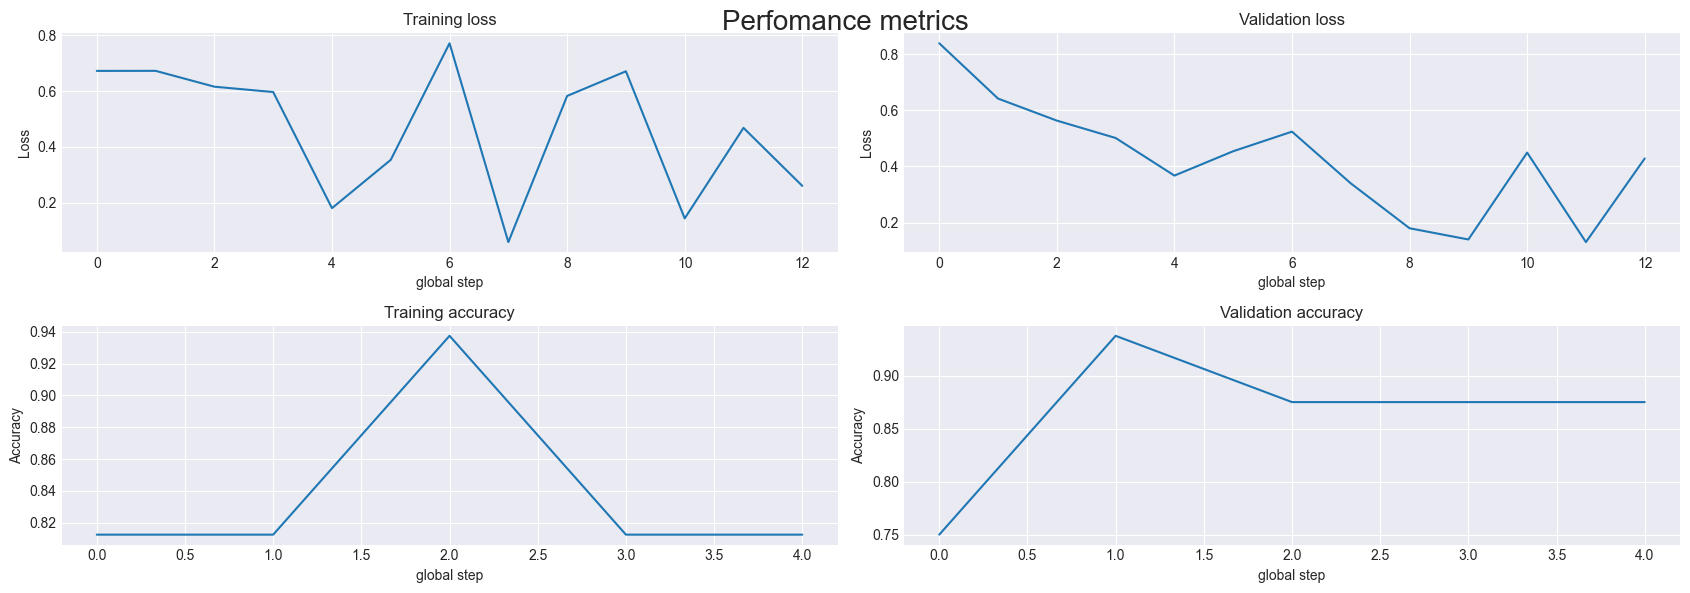

In [117]:
# Plotting the results

# Defining the array storages
losses = [train_losses, val_losses]
accuracies = [train_acc, val_acc]
labels = [["Training loss", "Validation loss"], ["Training accuracy", "Validation accuracy"]]
with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots(2, 2, figsize=(17, 6))
    # Plot losses
    for i, loss in enumerate(losses):
        ax[0, i].plot(loss)
        ax[0, i].set_title(labels[0][i])
        ax[0, i].set_xlabel("global step")
        ax[0, i].set_ylabel("Loss")
    # Plot accuracies
    for i, accuracy in enumerate(accuracies):
        ax[1, i].plot(accuracy)
        ax[1, i].set_title(labels[1][i])
        ax[1, i].set_xlabel("global step")
        ax[1, i].set_ylabel("Accuracy")
    fig.subplots_adjust(
        wspace=1.4,
        hspace=20
    )    
    plt.tight_layout()
    plt.suptitle("Perfomance metrics", fontsize=20)
    plt.show()


## Using the LLM as a spam classifier

In [154]:
# The classifier function

def classify_review(text, model=gpt_openAI, device=device, tokenizer=tokenizer, pad_token_id=50256, max_length=None):
    # Setting the model to evaluation mode
    # Encoding the text + batching
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
    # Getting the supported context length - positional layer.shape = [context_length, emb_dim]
    supported_context_length = model.pos_emb.weight.shape[0]
    # Getting the logits
    with torch.inference_mode():
        # Getting the logits
        logits = model(input_ids)
        # Getting the last row
        logits = logits[:, -1, :]
        # Getting the predicted label
        predicted_label = torch.argmax(logits, dim=-1)
    # Returning the class
    return "spam" if predicted_label == 1 else "ham"

In [196]:
# Testing the classifier

text = (
    "You are a winner you have been specially"
    "selected to receive $1000 cash or $2000 award."
)
print(f"\033[41m{classify_review(text_1, max_length=train_dataset.max_length)}\033[0m")

spam


In [197]:
torch.save(gpt_openAI.state_dict(), r"C:\Users\nyasa\Downloads\gpt2\review_classifier.pth")